<font size = 10><H1> Sleep Data Analysis</H1></font>

## Introduction & Objective

Aim of the project is to analyze user data from Samsung health app. The analysis would be done on the following files:
[calories_burned](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/calories_burned.csv)
[day_summary](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/day_summary.csv)
[Exercise](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/Exercise.csv)</n>
[floors_climbed](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/floors_climbed.csv)</n>
[heart_rate](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/heart_rate.csv)</n>
[sleep](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/sleep.csv)</n>
[sleep_data](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/sleep_data.csv)</n>
[step_count](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/step_count.csv)</n>
[step_daily_trend](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/step_daily_trend.csv)</n>
[stress](https://raw.githubusercontent.com/kshitijmamgain/Health-Analysis/master/datasets/stress.csv)</n>

<br>The schema of the project would be:
* Data Preprocessing
* Data Trend Analysis<br>
  i.   Sleep Trends<br>
  ii.  Exercise Trends<br>
  iii. Heart Rate Trends<br>
  iv.  Stress Trends<br>
  v.   Step Counts Trends<br>
* Data Daily Analysis<br>
  i.   Preparing a daily profile of the user using - step count, heart rate and sleep data

## Data Preprocessing

__About Samsung Health Data__: The data has been taken from a samsung user. The provided datasets would come under 3 classes defined by Samsung ([here](https://developer.samsung.com/onlinedocs/health/com/samsung/android/sdk/healthdata/HealthConstants.html)).:
* Activity: step_count, exercise, floors_climbed
* Rest: sleep, sleep_data
* Health Care: calories_burned, heart_rate, stress
* Summary: daily_summary, step_daily_trend

Time is a common feature in all the data following is the crucial information for data preprocessing

__HealthConstants.Common Field Summary__

| Modifier | Field | Description |
| --- | --- | --- |
| static String |	CREATE_TIME | UTC milliseconds when a data is created in the health data store.|
| static String |	DEVICE_UUID | Device identifier of the source device which provides a health data.|
| static String |	PACKAGE_NAME | Package name which provides a data.|
| static String |	UPDATE_TIME | UTC milliseconds when a data is updated.|
| static String |	UUID | Unique ID for each health data.|

__HealthConstants.SessionMeasurement Field Summary__

| Modifier |	Field | Description |
|---|---|---|
| static String | END_TIME | UTC milliseconds after the measurement has ended.
| static String	| START_TIME | UTC milliseconds when the measurement is started.
| static String	| TIME_OFFSET | Time offset which considers the time zone and daylight saving time.

<i><b>Keeping above information in mind, that the time columns are in UTC, we would apply the offset to the data during preprocessing</b><i><br>

<b> Import Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime
from datetime import timedelta
#import datetime
os.chdir(r'E:\PYTHON PRAC\Python Project')

<b>Defined Functions</b>

In [131]:

def dt_object(timestamp):
  
    dt_object = datetime.utcfromtimestamp(timestamp)
    return (dt_object)

def offset(dataframe,columnname_offset,columnname_torewrite):
   
    column_offset=[]
    hr= lambda a : int(a[3:6])
    mins= lambda a : int(a[3]+a[6:8])
    for i in dataframe.index:
        hour=(hr(dataframe[columnname_offset][i]))
        minute=(mins(dataframe[columnname_offset][i]))
        human_readable_time=pd.to_datetime(dataframe[columnname_torewrite][i], unit='ms')
        new_time=human_readable_time+datetime.timedelta(hours=hour, minutes=minute )
        column_offset.append(new_time)
    return column_offset

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

### Import the data

In [29]:
file = glob.glob('*')
file_list = []
for f in file:
    if f.endswith('.csv'):
        globals()['%s_df' % f.split('.')[0]] = pd.read_csv(f, index_col = 0)
        file_list.append('%s_df' % f.split('.')[0])

#drop null columns

for df in file_list:
    print(df)
    l = len(globals()[df])
    globals()[df].dropna(axis = 1, how = 'all', inplace = True)    

calories_burned_df
day_summary_df
Exercise_df
floors_climbed_df
heart_rate_df
sleep_df
sleep_data_df
step_count_df
step_daily_trend_df
stress_df


We now have 10 dataframes for the analysis, we will do the preprocessing first

In [58]:
"""## Sleep data
from datetime import datetime
# looking at the long column name can be confusing let's make the column names clean
new_cols = []
new_cols.append([col.split('.')[-1] for col in sleep_df.columns])
new_cols[0]

sleep_df.columns = new_cols[0]

# Also the column with time stamp should be converted to date time format we can use the same function defined above
time_stamp_cols = ['create_time', 'end_time', 'start_time', 'update_time']

for colname in time_stamp_cols:
    sleep_df[colname] = sleep_df.apply(lambda x: dt_object(x[colname]/1000), axis =1)


import datetime
# Apply the offset and create new columns. 
sleep_df['offset_starttime']=offset(sleep_df, 'time_offset', 'start_time')
sleep_df['offset_endtime']=offset(sleep_df, 'time_offset', 'end_time')


# let us clean data more to make it easier to comprehend
sleep_df.isnull().sum()
sleep_df.dropna(axis = 1, inplace = True)

# create new columns for weekday and sleep duration
sleep_df['weekday'] = [day.weekday() for day in sleep_df['start_time']]
sleep_df['sleep_duration'] = (sleep_df['end_time']-sleep_df['start_time'])/np.timedelta64(1,'h')

# add seperate columns for date and hour
sleep_df['start_date'] = [d.date() for d in sleep_df['offset_starttime']]
sleep_df['start_hour'] = [d.time() for d in sleep_df['offset_starttime']]
sleep_df['end_date'] = [d.date() for d in sleep_df['offset_endtime']]
sleep_df['end_hour'] = [d.time() for d in sleep_df['offset_endtime']]

# Sort values by start time
sleep_df.sort_values(by = ['start_time'], inplace = True)
sleep_df.reset_index(inplace = True)
sleep_df.drop([ 'index'], axis = 1 , inplace = True)

# Add a column with gap between 2 sleeps
sleep_df['sleep_gap'] = (sleep_df['start_time'].shift(-1) - sleep_df['end_time'])/np.timedelta64(1,'h')
"""
"""#Heart rate#
heart_rdf = heart_rate_df[['heart_rate', 'end_time', 'time_offset', 'deviceuuid']].copy()
# Convert string type to datetime
heart_rdf['end_time'] = pd.to_datetime(heart_rdf['end_time'])
# seperate column for date
heart_rdf['date'] = [d.date() for d in heart_rdf['end_time']]
# seperate column for time
heart_rdf['hour'] = [d.time() for d in heart_rdf['end_time']]
# sort values
heart_rdf.sort_values(by = ['end_time'], inplace = True)
heart_rdf.reset_index(inplace = True)
heart_rdf.drop(heart_rdf.index[[0,1]], inplace = True)
heart_rdf.drop('index', axis =1 ,inplace = True)

#time offset
heart_rdf['offset_hour'] = (heart_rdf.time_offset.str.split("C").str[1].astype(int))/100

oh = list(heart_rdf['offset_hour'])

for i,val in enumerate(oh):
    if val == 5.3:
        oh[i] = 5.5
    else:
        pass

td = []

for hr in oh:
    td.append(datetime.timedelta(hours = hr))
heart_rdf['delta_time'] = td
heart_rdf['adjusted_time'] = heart_rdf['end_time']+heart_rdf['delta_time']
"""
"""heart_rdf.head(3)
from datetime import datetime
step_daily_trend_df['date'] = step_daily_trend_df.apply(lambda x: datetime.fromtimestamp(x['day_time']/1000), axis =1)
step_daily_trend_df.head(3)"""
"""import datetime
from datetime import timedelta
step_count_df['start_time'] = pd.to_datetime(step_count_df['start_time'])
step_count_df['end_time'] = pd.to_datetime(step_count_df['end_time'])

step_count_df['offset_hour'] = (step_count_df.time_offset.str.split("C").str[1].astype(int))/100
oh = list(step_count_df['offset_hour'])

for i,val in enumerate(oh):
    if val == 5.3:
        oh[i] = 5.5
    else:
        pass

td = []

for hr in oh:
    td.append(datetime.timedelta(hours = hr))

step_count_df['timedelta'] = td

step_count_df.head(3)"""
"""# Convert string type to datetime
stress_df['start_time'] = pd.to_datetime(stress_df['start_time'])
# seperate column for date
stress_df['date'] = [d.date() for d in stress_df['start_time']]
# seperate column for time
stress_df['hour'] = [d.time() for d in stress_df['start_time']]
stress_df.head(3)"""

step_count_df['offset_etime'] = step_count_df['end_time']+step_count_df['timedelta']
"""# Convert string type to datetime
floors_climbed_df['start_time'] = pd.to_datetime(floors_climbed_df['start_time'])

# Convert string type to datetime
floors_climbed_df['end_time'] = pd.to_datetime(floors_climbed_df['end_time'])
# seperate column for date
floors_climbed_df['date'] = [d.date() for d in floors_climbed_df['start_time']]
# seperate column for time
floors_climbed_df['hour'] = [d.time() for d in floors_climbed_df['start_time']]
floors_climbed_df.head(3)"""

from datetime import datetime
step_daily_trend_df['date'] = step_daily_trend_df.apply(lambda x: datetime.fromtimestamp(x['day_time']/1000), axis =1)


# 1. Data Exploration

(736107.8333333334, 737190.8333333334)

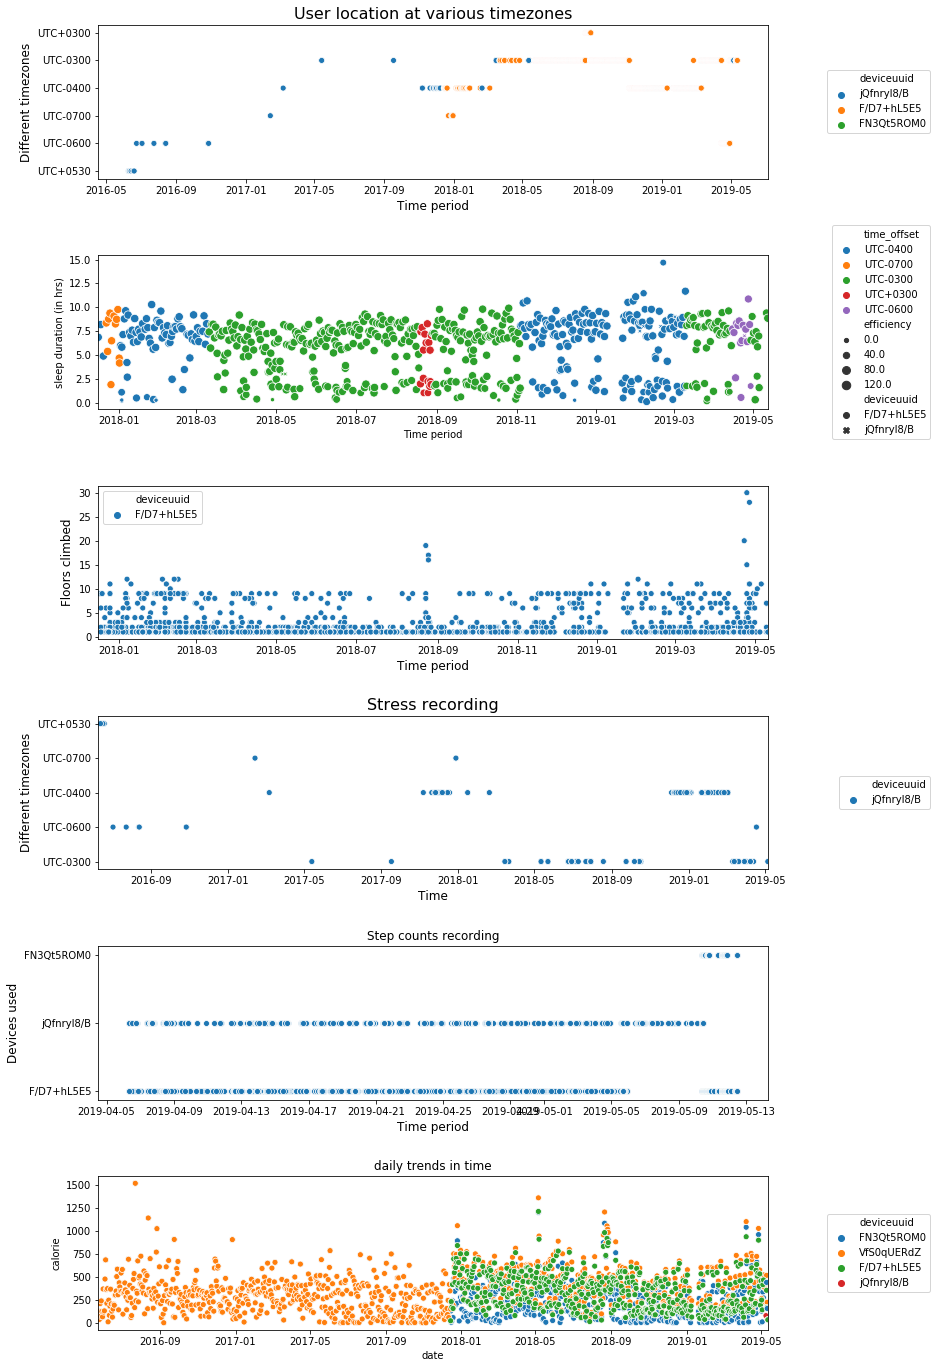

In [77]:

fig,axs = plt.subplots(6,1, figsize = (12,24))
fig.subplots_adjust(hspace=.5)
ax1 = plt.subplot(612)
ax1 = sns.scatterplot(x=sleep_df['start_time'],
                     y=sleep_df['sleep_duration'], 
                     hue = sleep_df['time_offset'], 
                     size = sleep_df['efficiency'],
                     style = sleep_df['deviceuuid'],
                      cmap = 'YlGnBU')
ax1.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax1.set_xlim(min(sleep_df['start_time']), max(sleep_df['start_time']))
ax1.set_xlabel('Time period')
ax1.set_ylabel('sleep duration (in hrs)')

# heart, Let us see the history of user
#plt.figure(figsize = (14,6))
ax2 = plt.subplot(611)
ax2 = sns.scatterplot(heart_rdf.end_time,heart_rdf.time_offset, hue = heart_rdf.deviceuuid, alpha = 1)
ax2.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
#ax2.set_xlim(datetime.date(2016,5,8), datetime.date(2019,6,30))
ax2.set_title("User location at various timezones", size = 16)
ax2.set_xlabel("Time period", size = 12)
ax2.set_ylabel("Different timezones", size = 12)

# Floors
ax3 = plt.subplot(613)
ax3 = sns.scatterplot(x = "date", y = "floor", data = floors_climbed_df, hue = "deviceuuid")
ax3.set_xlim(min(floors_climbed_df.date),max(floors_climbed_df.date))
ax3.set_xlabel("Time period", size = 12)
ax3.set_ylabel("Floors climbed", size = 12)

# Stress
# Let us see the history of user
ax4 = plt.subplot(614)
ax4 = sns.scatterplot(stress_df.start_time,stress_df.time_offset, hue = stress_df.deviceuuid)
ax4.set_xlim(min(stress_df.start_time), max(stress_df.start_time))
ax4.set_title("Stress recording", size = 16)
ax4.set_xlabel("Time", size = 12)
ax4.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax4.set_ylabel("Different timezones", size = 12)

# Step Count
ax5 = plt.subplot(615)
ax5 = sns.scatterplot(x = step_count_df.offset_etime, y = step_count_df.deviceuuid)
ax5.set_xlabel("Time period", size = 12)
ax5.set_ylabel("Devices used", size = 12)
ax5.set_title("Step counts recording")

# daily trends
ax6 = plt.subplot(616)
ax6 =  sns.scatterplot(x="date",y="calorie",data=step_daily_trend_df, hue="deviceuuid")
ax6.set_title("daily trends in time")
ax6.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax6.set_xlim(min(step_daily_trend_df.date),max(step_daily_trend_df.date))

# 2. User Sleep Analysis

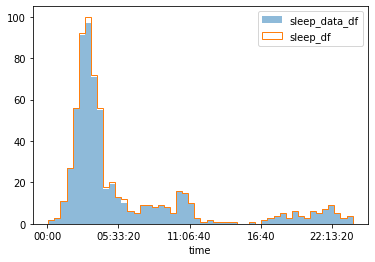

In [88]:
# There are two datasets for sleep
# 1. Sleep_df
# 2. Sleep_data_df
# Let us explore how different they are from each other!
# comparison of data with histograms
# converting to datetime
#sleep_data_df['start_time'] = pd.to_datetime(sleep_data_df['start_time'])
#%matplotlib inline
ax1 = plt.hist([d.time() for d in sleep_data_df['start_time']], label = 'sleep_data_df', bins = 50, alpha = 0.5)
ax2 = plt.hist([d.time() for d in sleep_df['start_time']], bins = 50, alpha = 1, histtype = 'step')
plt.legend(('sleep_data_df','sleep_df'))

Since the values are similar in both datasets we are going to use just one dataset for the analysis i.e. sleep_df

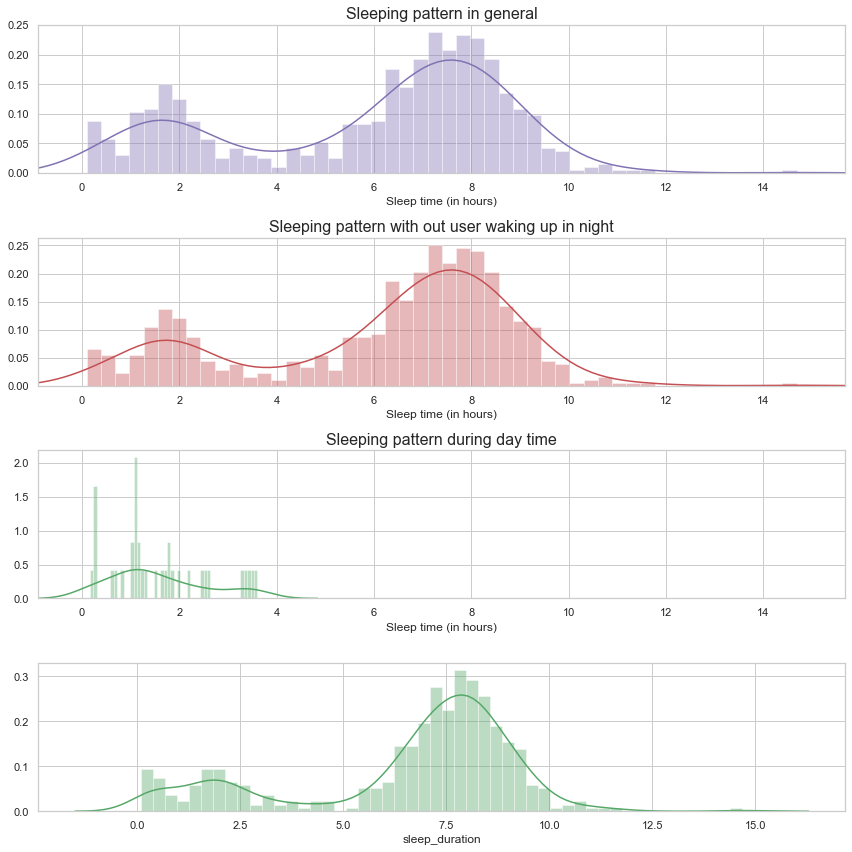

In [114]:
# now check for disrupted sleep
sleep_df['Disrupted']=(sleep_df.sleep_gap < 2) & (sleep_df.sleep_duration < 4)

fig,axs = plt.subplots(4,1, figsize = (12,12))

#sns.set()
#sns.set_style("whitegrid")
ax1 = plt.subplot(411)
ax1 = sns.distplot(sleep_df['sleep_duration'], color="m", bins = 50)
ax1.set_xlim(sleep_df['sleep_duration'].min()-1, sleep_df['sleep_duration'].max() + 1 )
ax1.set_xlabel('Sleep time (in hours)')
ax1.set_title('Sleeping pattern in general', size = 16)


#sns.set()
#sns.set_style("whitegrid")
ax2 = plt.subplot(412)
ax2 = sns.distplot(sleep_df[sleep_df.Disrupted == False]['sleep_duration'], color="r", bins = 50)
ax2.set_xlim(sleep_df['sleep_duration'].min()-1, sleep_df['sleep_duration'].max() + 1 )
ax2.set_xlabel('Sleep time (in hours)')
ax2.set_title('Sleeping pattern with out user waking up in night', size = 16)

ax3 = plt.subplot(413)
ax3 = sns.distplot(sleep_df[sleep_df.Disrupted == True]['sleep_duration'], color="g", bins = 50)
ax3.set_xlim(sleep_df['sleep_duration'].min()-1, sleep_df['sleep_duration'].max() + 1 )
ax3.set_xlabel('Sleep time (in hours)')
ax3.set_title('Sleeping pattern during disrupted sleeps', size = 16)
plt.tight_layout()

#sleep_df['waking_hour'] = sleep_df.apply(lambda a: a['end_time'].hour, axis =1)

ax4 = plt.subplot(414)
ax4 = sns.distplot(sleep_df[(sleep_df.waking_hour >= 10) &(sleep_df.waking_hour <= 19)]['sleep_duration'], color="g", bins = 50)
ax3.set_xlim(sleep_df['sleep_duration'].min()-1, sleep_df['sleep_duration'].max() + 1 )
ax3.set_xlabel('Sleep time (in hours)')
ax3.set_title('Sleeping pattern during day time', size = 16)
plt.tight_layout()


## 3. User Sleeping Trends

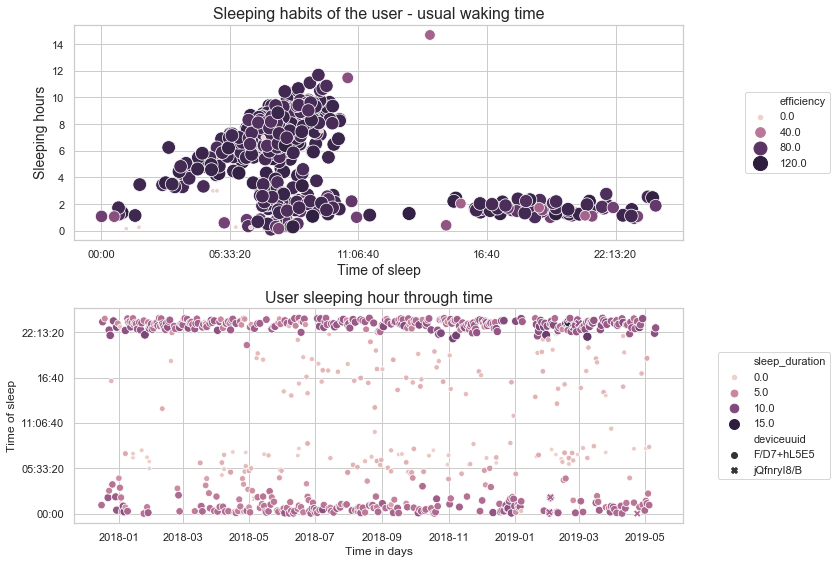

In [124]:
# Visualizing the habits
fig,axs = plt.subplots(2,1, figsize = (12,8))
ax1 =plt.subplot(211)
ax1 = sns.scatterplot(sleep_df['end_hour'], 
                      sleep_df['sleep_duration'], 
                      hue = sleep_df['efficiency'],
                      size = sleep_df['efficiency'], sizes=(20,200))
ax1.set_xlabel('Time of sleep', size = 14)
ax1.set_ylabel('Sleeping hours', size = 14)
ax1.set_title('Sleeping habits of the user - usual waking time', size = 16)
ax1.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

ax2 =plt.subplot(212)
ax2 = sns.scatterplot(sleep_df['start_date'], 
                        sleep_df['start_hour'], 
                        hue = sleep_df['sleep_duration'], 
                        size= sleep_df['sleep_duration'],sizes=(20, 100),
                        style=sleep_df['deviceuuid'])
ax2.set_title('User sleeping hour through time', size = 16)
ax2.set_xlabel('Time in days')
ax2.set_ylabel('Time of sleep')
ax2.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.tight_layout()

## 4. User Exercise Trends

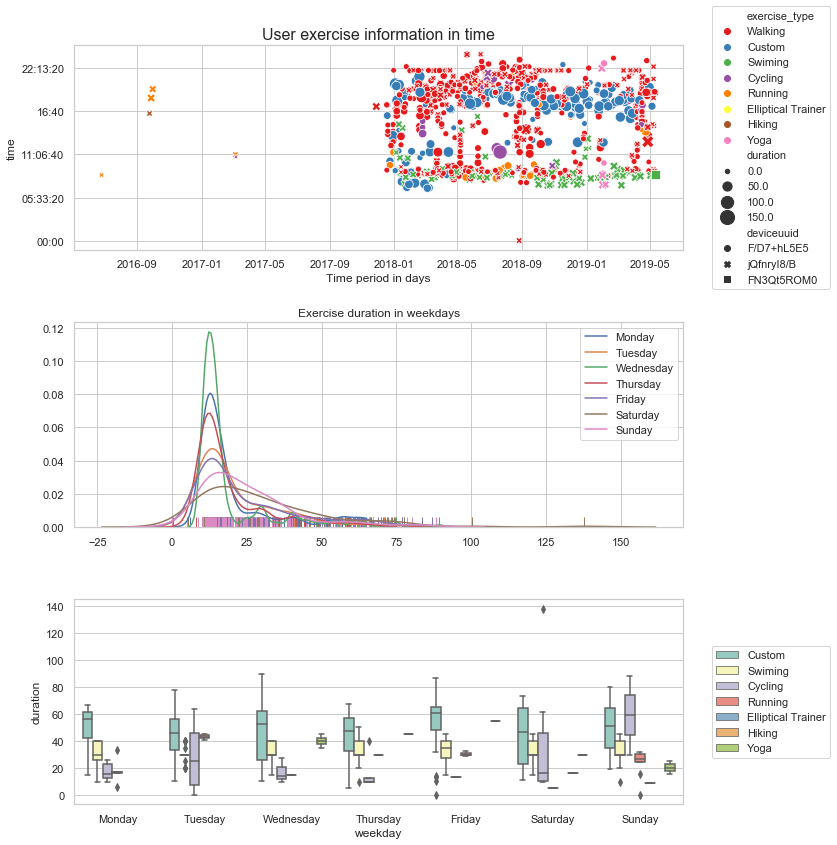

In [188]:
"""Exercise_df.columns
Exercise_df['start_time'] = pd.to_datetime(Exercise_df['start_time'])
Exercise_df['start_time'] = pd.to_datetime(Exercise_df['start_time'])
Exercise_df['end_time'] = pd.to_datetime(Exercise_df['end_time'])
Exercise_df['offset_starttime']=offset(Exercise_df, 'time_offset', 'start_time')
Exercise_df['offset_endtime']=offset(Exercise_df, 'time_offset', 'end_time')
Exercise_df.exercise_type.value_counts()

Exercise_df['exercise_type'] = Exercise_df['exercise_type'].map({1001:'Walking', 0: 'Custom', 14001:'Swiming',
                                                                  11007:'Cycling',1002:'Running',9002:'Yoga',
                                                                  13001:'Hiking',15006:'Elliptical Trainer'})
Exercise_df['weekday'] = Exercise_df.apply(lambda x: x['offset_endtime'].weekday(), axis =1)
Exercise_df.duration = Exercise_df.duration/60000
Exercise_df['weekday'] = Exercise_df['weekday'].map({0:"Monday", 1: "Tuesday", 2:"Wednesday",
                                                                  3:"Thursday",4:"Friday",5:"Saturday",
                                                                  6:"Sunday"})"""
#order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]

axs, fig = plt.subplots(3,1, figsize = (12,12))
ax1 = plt.subplot(311)
ax1 = sns.scatterplot([d.date() for d in Exercise_df.offset_starttime], 
                     [d.time() for d in Exercise_df.offset_starttime],
                     hue = 'exercise_type',
                     size = 'duration',
                     sizes=(20,200),
                     style = "deviceuuid",
                     data = Exercise_df,
                     palette="Set1")
ax1.set_title("User exercise information in time", size = 16)
ax1.set_xlabel("Time period in days")
ax1.set_ylabel
ax1.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)


ax3 = plt.subplot(312)
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Monday'][['duration']], hist=False, rug=True, label = 'Monday')
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Tuesday'][['duration']], hist=False, rug=True, label ='Tuesday')
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Wednesday'][['duration']], hist=False, rug=True, label ='Wednesday')
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Thursday'][['duration']], hist=False, rug=True, label = 'Thursday')
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Friday'][['duration']], hist=False, rug=True, label = 'Friday')
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Saturday'][['duration']], hist=False, rug=True, label = 'Saturday')
ax3 =sns.distplot(Exercise_df[Exercise_df['weekday']=='Sunday'][['duration']], hist=False, rug=True, label ='Sunday')
ax3.set_title("Exercise duration in weekdays")

ax4 = plt.subplot(313)
ax4 = sns.boxplot(x="weekday", y="duration", data=Exercise_df[Exercise_df.exercise_type != "Walking"],
                 hue = 'exercise_type',palette="Set3", order = order)
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.tight_layout()

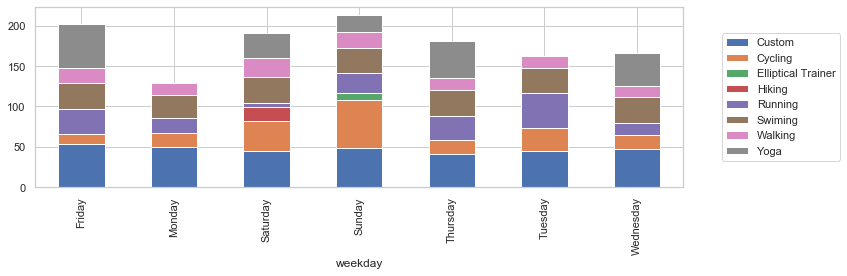

In [187]:
ax2 = Exercise_df.groupby(['weekday','exercise_type']).mean()['duration'].unstack().plot(kind ='bar', stacked=True, figsize=(12,4))
ax2.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.tight_layout()

## 5. Heart Rate Trend

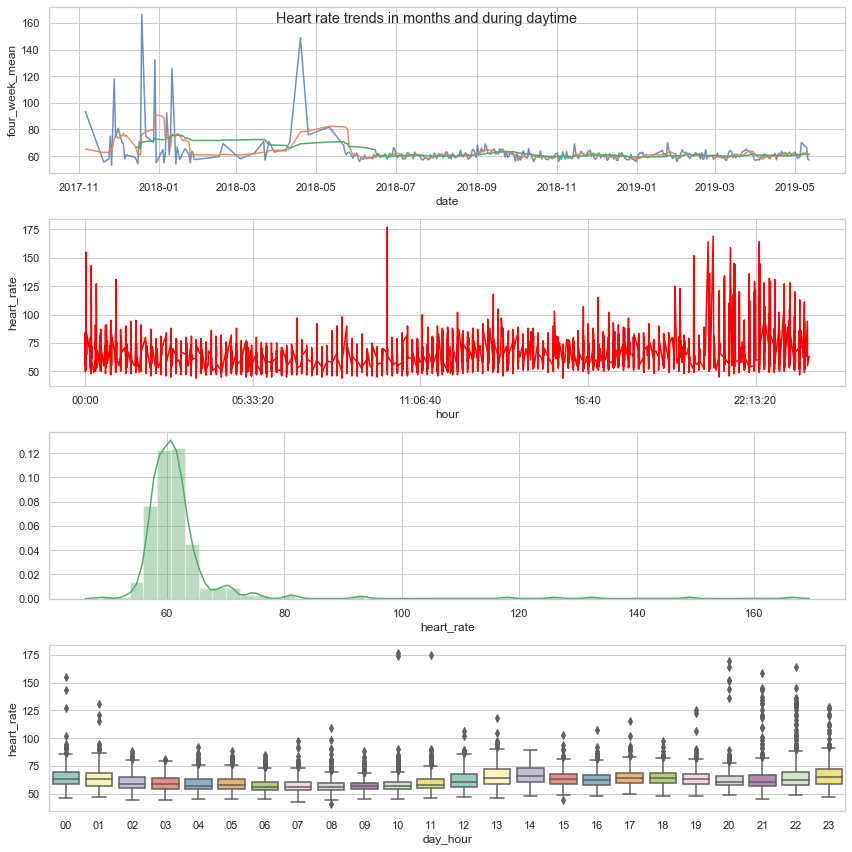

In [221]:
"""#heart_rate_df.head(3)
heart_year = heart_rdf[['date','heart_rate']].groupby('date').mean().reset_index()
weekly_mean=heart_year.heart_rate.rolling(window=7).mean()
heart_year['weekly_mean']=weekly_mean
fourweekmean=heart_year.heart_rate.rolling(window=28).mean()
heart_year['four_week_mean']=fourweekmean
heart_year.head(3)"""
#import datetime
axs, fig = plt.subplots(4,1, figsize = (12,12))
# Plot the diagram
ax1 = plt.subplot(411)
ax1 = sns.lineplot(heart_year[heart_year['date']> datetime.date(2017,10,31)].date, 
             heart_year[heart_year['date']> datetime.date(2017,10,31)].heart_rate, 
             alpha = 0.8)
ax1 = sns.lineplot(heart_year[heart_year['date']> datetime.date(2017,10,31)].date, 
             heart_year[heart_year['date']> datetime.date(2017,10,31)].weekly_mean, 
             alpha = 0.9)
ax1 = sns.lineplot(heart_year[heart_year['date']> datetime.date(2017,10,31)].date, 
             heart_year[heart_year['date']> datetime.date(2017,10,31)].four_week_mean, 
             alpha = 1)

# Average heart rate during the day

#heart_day = heart_rdf[['hour','heart_rate']].groupby('hour').mean().reset_index()
ax2 = plt.subplot(412)
ax2 = sns.lineplot(heart_day.hour, heart_day.heart_rate, alpha = 1, color ="red")

ax3 = plt.subplot(413)
ax3= sns.distplot(heart_year.heart_rate, bins = 50, color ='g')

# heart_rdf['day_hour'] = [d.strftime('%H') for d in heart_rdf.end_time]
ax4 = plt.subplot(414)
ax4 = sns.boxplot(x="day_hour", y="heart_rate",  data=heart_rdf[heart_rdf['date']> datetime.date(2017,10,31)], palette="Set3")
plt.suptitle("Heart rate trends in months and during daytime")
plt.tight_layout()

## 6 Stress Trends

C:\Users\Kshitij\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Kshitij\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\Kshitij\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Kshitij\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


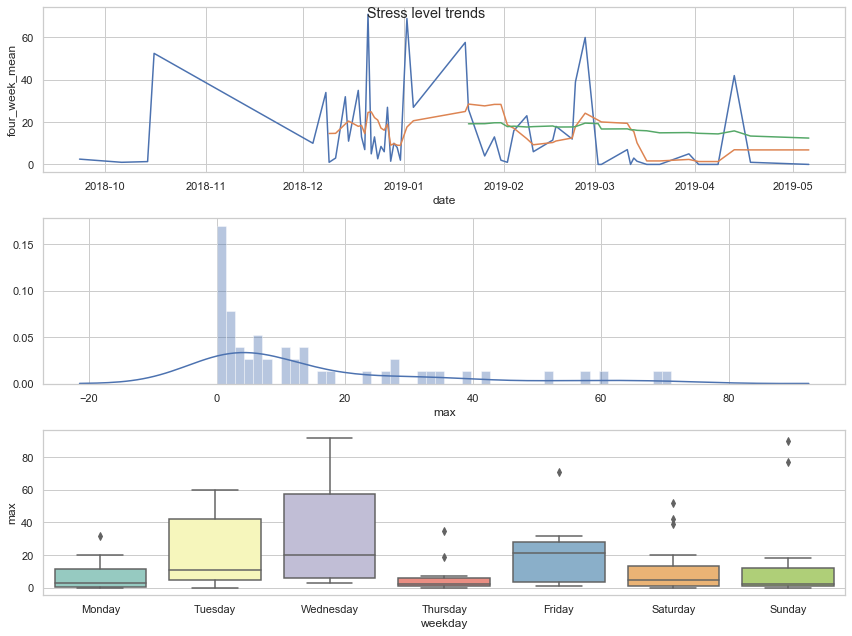

In [233]:
"""stress_year = stress_df[['date','max']].sort_values(by = 'date').groupby('date').mean().reset_index()
weekly_mean=stress_year['max'].rolling(window=7).mean()
stress_year['weekly_mean']=weekly_mean
fourweekmean=stress_year['max'].rolling(window=28).mean()
stress_year['four_week_mean']=fourweekmean
stress_year.head(3)"""
axs, fig = plt.subplots(4,1, figsize = (12,9))
ax1 = plt.subplot(311)
ax1 = sns.lineplot(stress_year.date, 
             stress_year['max'])
ax1 = sns.lineplot(stress_year.date, 
             stress_year.weekly_mean)
ax1 = sns.lineplot(stress_year.date, 
             stress_year.four_week_mean)
ax2 = plt.subplot(312)
ax2 = sns.distplot(stress_year['max'], bins = 50)
#stress_df['weekday'] = [day.weekday() for day in stress_df['date']]
#stress_df['weekday'] = stress_df['weekday'].map({0:"Monday", 1: "Tuesday", 2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",
                                                                         # 6:"Sunday"})
ax3 = plt.subplot(313)
ax3 = sns.boxplot(x="weekday", y="max",  data=stress_df, palette="Set3", order = order)
plt.suptitle("Stress level trends")
plt.tight_layout()

In [234]:
stress_df.weekday.value_counts()

Sunday       32
Saturday     29
Friday       22
Monday       21
Thursday     20
Tuesday      19
Wednesday     9
Name: weekday, dtype: int64

As we could see the data is not significant to make an assessment on the user stress levels but we observe that for similar values Wednesdays and Tuesdays have more stress range

## 7 Step Counts Trends

<Figure size 1152x432 with 0 Axes>

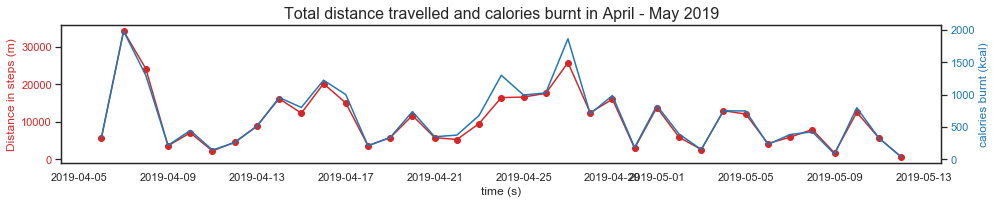

In [245]:
"""step_count_df['date'] =  [d.date() for d in step_count_df['offset_etime']]
step_count_df.head()

# let us see calories and steps for time period
sc_df1 = step_count_df.groupby('date').sum().reset_index()"""
plt.figure(figsize = (16,6))
sns.set_style("white")
fig, ax1 = plt.subplots(figsize = (14,3))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Distance in steps (m)', color=color)
ax1.plot(sc_df1.date, sc_df1.distance, color=color, marker = 'o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('calories burnt (kcal)', color=color)  # we already handled the x-label with ax1
ax2.plot(sc_df1.date, sc_df1.calorie, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Total distance travelled and calories burnt in April - May 2019", size = 16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

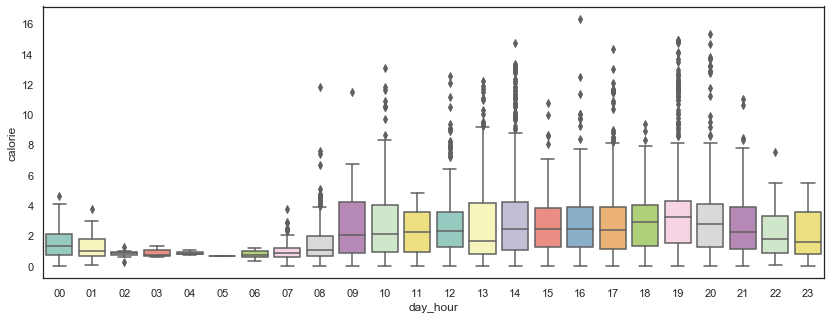

In [256]:
step_count_df.head()
step_count_df['day_time'] = [d.time() for d in step_count_df.offset_etime]
step_count_df['day_hour'] = [d.strftime('%H') for d in step_count_df.day_time]
step_count_df.head()
plt.figure(figsize = (14,5))
sns.boxplot(x="day_hour", y="calorie",  data=step_count_df, palette="Set3")

## 8 Floors Climbed Trend

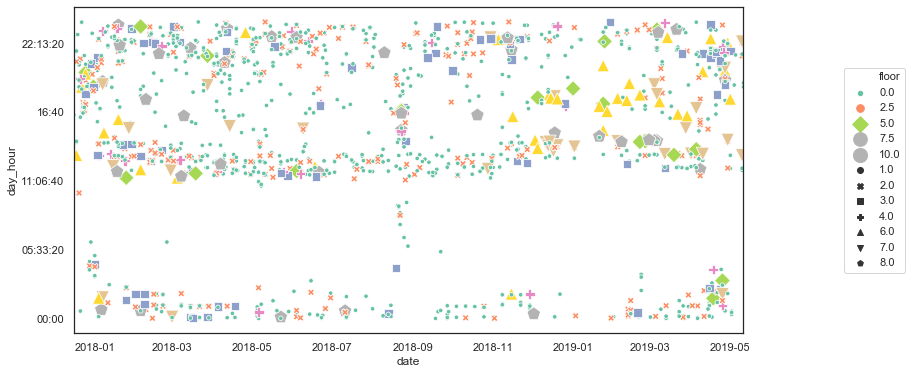

In [289]:
"""# Convert string type to datetime
floors_climbed_df['start_time'] = pd.to_datetime(floors_climbed_df['start_time'])

# Convert string type to datetime
floors_climbed_df['end_time'] = pd.to_datetime(floors_climbed_df['end_time'])
# seperate column for date
floors_climbed_df['date'] = [d.date() for d in floors_climbed_df['start_time']]
# seperate column for time
floors_climbed_df['hour'] = [d.time() for d in floors_climbed_df['start_time']]
floors_climbed_df.head(3)

floors_climbed_df['day_hour'] = floors_climbed_df.hour.apply(lambda x: (x.replace(second=0, microsecond=0)))
"""
#floor_s = floors_climbed_df[["date","hour", "day_hour","floor"]].sort_values(by = "date")

plt.figure(figsize = (12,6))
sns.scatterplot(x = "date", y = "day_hour", size = "floor",hue="floor", style = "floor",data = floors_climbed_df[floors_climbed_df.floor<9],palette="Set2",sizes=(20, 200))
plt.xlim(min(floors_climbed_df.date),max(floors_climbed_df.date))
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

# Daily Trends
Let's now see day-wise profile of the user. We would attempt to create a peek into life of user using multplue datasets. 

In [259]:
# let us try to define a function to see daily activity of the user

# since the data is for step count begins from 6the april we would pick the same date for all the dfs
heart_month = heart_rdf[(heart_rdf.date >= datetime.date(2019, 4, 6))&(heart_rdf.date <= datetime.date(2019, 5, 5))]
steps_month = step_count_df[(step_count_df.date >= datetime.date(2019, 4, 6))&(step_count_df.date <= datetime.date(2019, 5, 5))]
sleep_month = sleep_df[(sleep_df.start_date >= datetime.date(2019, 4, 6))&(sleep_df.start_date <= datetime.date(2019, 5, 5))]

list_1 = heart_month.groupby(['date']).sum().index


In [273]:
def comp_graphs(i):
    df_h = heart_month[heart_month.date == list_1[i]].sort_values(by = 'hour')
    df_steps = steps_month[steps_month.date == list_1[i]].sort_values(by = 'day_time')
    wk_tm = list((sleep_month[sleep_month['end_date'] == list_1[i]]['offset_endtime']).dt.time)[0]
    sl_tm = list((sleep_month[sleep_month['end_date'] == list_1[i]]['offset_starttime']).dt.time)[0]
    mnth_dt = list((sleep_month[sleep_month['end_date'] == list_1[i]]['offset_endtime']).dt.date)[0]
    
    fig, ax1 = plt.subplots(figsize = (16,8))
    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Hear beat', color=color)
    hr = ax1.plot(df_h.hour,df_h.heart_rate, color=color, marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    #plt.figure(figsize = (16,6))
    color = 'tab:blue'
    ax2.set_ylabel('calories burnt (kcal)', color=color)  # we already handled the x-label with ax1
    cal = ax2.plot(df_steps.day_time,df_steps.calorie, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    el = ax2.axvline(x=sl_tm, ymin=0, ls='-.', color = 'black')
    sl = ax1.axvline(x=wk_tm, ymin=0, ls='--', color = 'black')
    plt.title("User's day wise activity pattern for {}".format(mnth_dt), size = 24)
    plt.legend([el,sl], ["Sleep time","Wake time"])
    plt.tight_layout()  # otherwise the right y-label is slightly clipped
    return ax1, ax2


90922


(<matplotlib.axes._subplots.AxesSubplot at 0x1dc15a22f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dc15abcf98>)

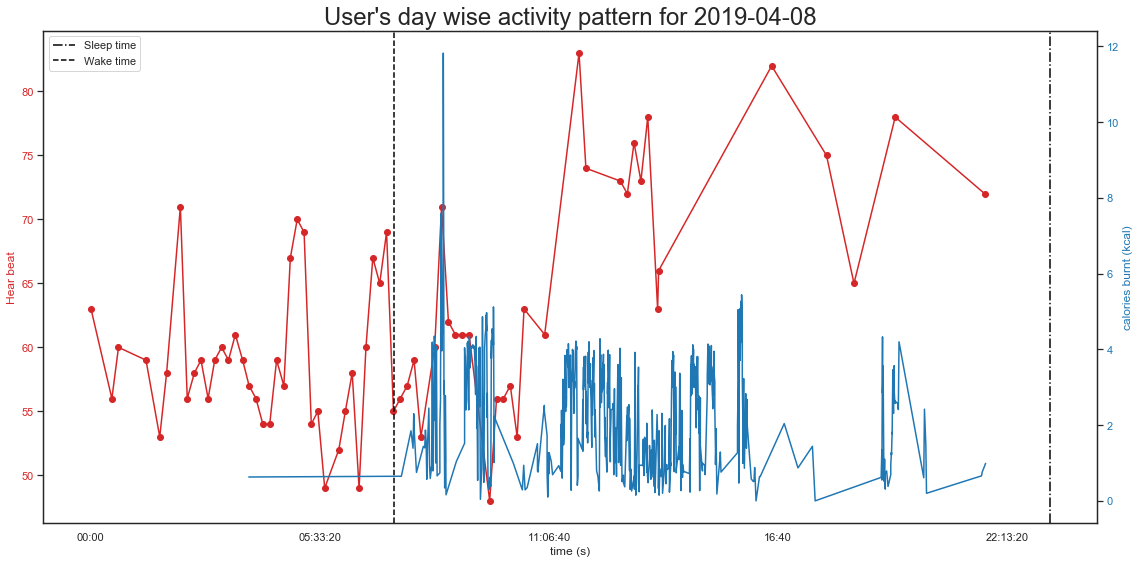

In [274]:
comp_graphs(int(input(i)))

909215


(<matplotlib.axes._subplots.AxesSubplot at 0x1dc12334240>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dc0ff35128>)

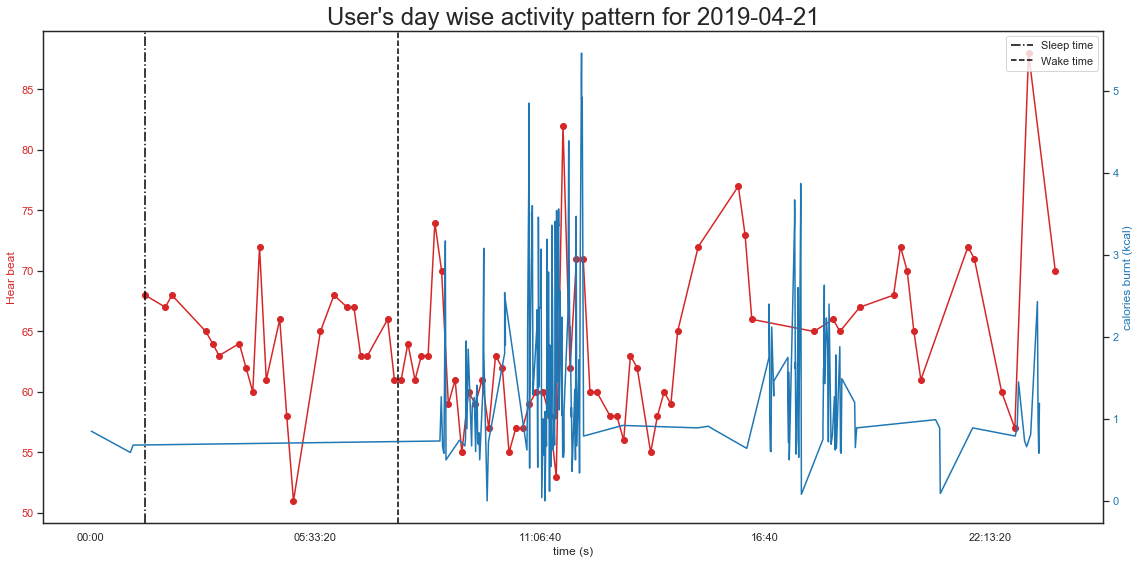

In [275]:
comp_graphs(int(input(i)))

909228


(<matplotlib.axes._subplots.AxesSubplot at 0x1dc0df5de48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dc0edc5748>)

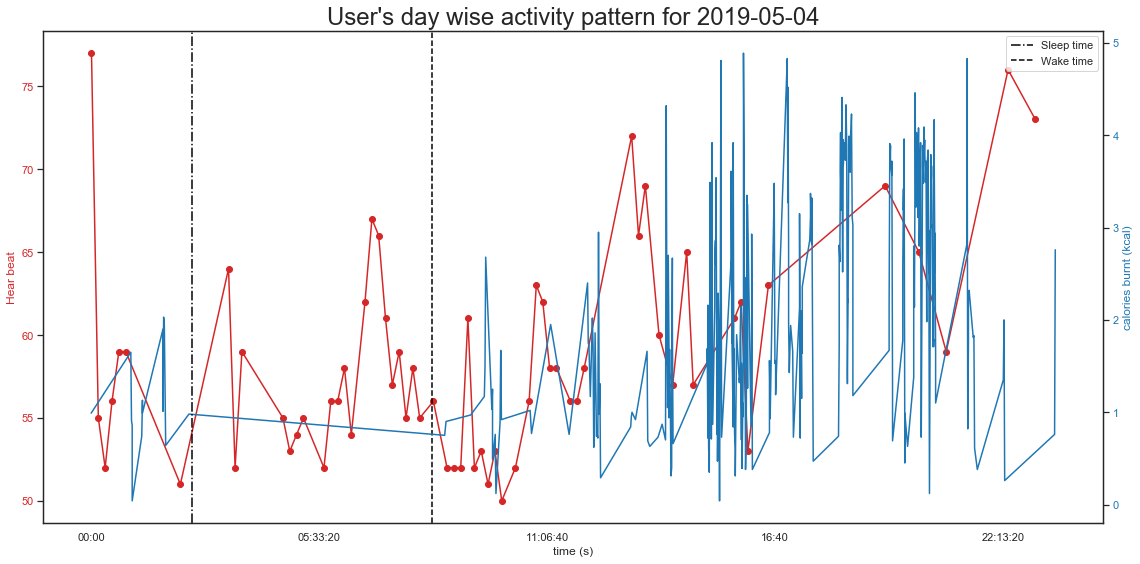

In [277]:
comp_graphs(int(input(i)))

909214


(<matplotlib.axes._subplots.AxesSubplot at 0x1dc129a6630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dc0fcadb00>)

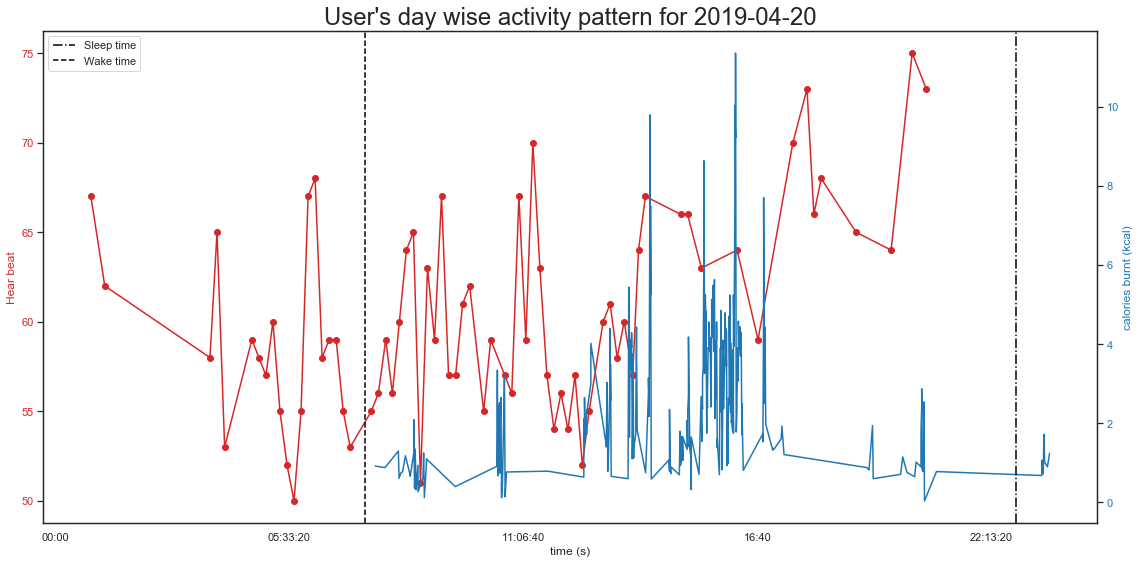

In [279]:
comp_graphs(int(input(i)))

# Conclusions
We could conclude our project with the following key observations
<br></br>
<br></br>

__CONCLUSION 1: Data Exploration__ From the scatterplot above we could infer the following:
1. User had one samsung device to track in the beginning and as time progressed he got few more gadgets.
2. From the unique device id it could be ascertained that none of the device were discarded by the user since all are in use. 
3. By the information from samsung we could conclude that<br>
   i. User lives in East Central timezone, probably Toronto (or New York?) and frequently travels to a location at Central timezone like Winnipeg<br>
   ii. The earlies data starts from India standard time and the user could be a techie who immigrated in 2016<br>
   iii.User had a mobile with S-Health app since May 2016 this device was being used to record stress<br>
   iv. User got a new Samsung wrist watch in January 2018, he also got another phone same time, but he has started using it recently for health tracking
<br></br>
<br></br>

### Trends Analysis
__Conclusion 2: Sleep Analysis__ From the distribution plots about the sleep pattern we see that the user has bimodal distribution:
1. In general he/she takes the average sleep of 8 hours but there are times when the user also sleeps for average of 4 hours
2. We also investigated that if the bimodal behaviour is because the user might get up at night and that is being considered as a sleep time but we see that even when sleep is not disrupted the user has similar pattern in sleeping
3. We also wanted to consider whether there is any change in users sleeping habit during day time (which we arbitrarily defined between 10 am to 7 pm but we observe a similar sleep ing pattern, so we could conclude that the user also works in shifts
<br></br>
<br></br>
__Conclusion 3: User Sleep Trends__ From the 2 scatterplots we could conclude that:
1. User usually have similar waking and sleeping schedule but also sleeps during the day time 
2. The above graphs indicate us that pattern has remained consistent over the time period which means that user has'nt made any transition in lifestyle in this period
<br></br>
<br></br>
__Conclusion 4: User Exercise Trends__ We could conclude the following from the above scatterplot:
1. The user has become aware of tracking his exercise in 2018 probably when he/she bought his/her new wrist watch.
2. From exercise data we could see that his earlier device is tracking the swimming schedule, while the new smart wrist watch is not. May be it is by design that the swimming type gets registerd in the mobile that the user uses
3. The user is fairly regular in the time when he is swimming or when he is doing his custom exercise
4. While he is regular in swimming in across the week for 30 - 40 mins in the mornings, during the evening user spends more time in custom exercise, especially over the weekends
<br></br>
<br></br>
__Conclusion 5: Heart Rate Trends__ The heart rate graphs show that around 9 pm there is a trend of increase, this coincides with the timing of custom exercise from the Exercise data, this could mean that the user is involved we some intensive exercise
<br></br>
<br></br>
__Conclusion 6: User Stress Trends__ The stress levels are measured by the samsung health mobile app by placing the finger tip on the sensor, since the information is limited it may be possible that insights are biased<br>
Sunday       32<br>
Saturday     29<br>
Friday       22<br>
Monday       21<br>
Thursday     20<br>
Tuesday      19<br>
Wednesday     9<br>
<br></br>
<br></br>
__Conclusion 7: Steps Count Trend__ The data reveals that user has increase activity at lunch time and in the evening aroung 7pm, the range for the steps is also high during the morning time probably when the user rushes to the ofice. May be user takes the stairs during lunch and evening time from the office as it reflects on increased step counts during that period
<br></br>
<br></br>
__Conclusion 8: User Floors Climbed__ The data reveals that most likely user lives at first floor since one floor has the highest frequency, also the chances are that his office is at the 7 or 8 floor in a building because that is the time when he would use stairs in the evening adding to increased step counts

## Daily Trends
__Conclusion 9:__ The datasets from sleep, heart rate and step counts were combined to see the lifestyle that user has in the month of April 2019. Various trends were observed for the user, such as:
* Punctuality in waking up around 7 am
* Going for a walk at lunch time
* And odd hours for sleeping

<font size = 1>Note: The Daily trends could be further evolved to integrate information from exercise and data to see the activity chart of the individual</font>

<font size= 1> Submitted by Kshitij Mamgain